### imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import cv2 as cv
import os

## Metrics

<pre>
Since dataset is not imbalanced .
1. Accuracy can be the relative measure.

2. It is the binary classification problem, So loss could be binary loss or categorical crossentropy(logloss) could 
be best.
</pre>


In [29]:
train_dir = "ToyDataset/toy_train"

<pre>
Since dataset is small we will use dataloader form keras.
</pre>

In [70]:
count = os.listdir(os.path.join(train_dir,"circle"))
print("Train data circle: ",len(count))
count = os.listdir(os.path.join(train_dir,"rectangle"))
print("Train data rectangle",len(count))

Train data circle:  494
Train data rectangle 506


#### Dataloader

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    
    rescale=1./255,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

In [36]:
image_dim = (64,64)
batch_size = 64

In [37]:
train_generator = train_datagen.flow_from_directory(

                    directory='ToyDataset/toy_train/',
                    target_size=image_dim,
                    batch_size=batch_size,
                    
)

validation_generator = val_datagen.flow_from_directory(
    'ToyDataset/toy_val/',
    target_size=image_dim,
    batch_size=batch_size,
    )

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### reviewing the images

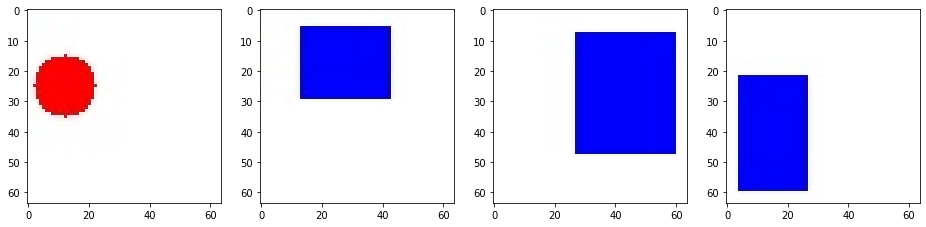

In [38]:
plt.figure(figsize=(16,4))
for i,img in enumerate(train_generator[0][0][:4]):
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
     

<pre>
Since provided image is the color image so color might be the dominating factor SO our cnn model could use color to detect the 
circle and rectangle which would be wrong. 

One possible solution could be 

1. Use black and white images rather than color images.(this will remove the effect the color effect)
2. Augmentation can be done like detecting the edges ( since this will be done or learn in begining of the cnn )
</pre>

### Developing the Model

<pre>
<b> Model 1 </b>

without feature processing.

we will try to learn the small feature at the beginnig so using small filter size at the begining of the model and increase our filter. or filter can be kept small tough out the process.
</pre>

In [70]:
image_size = (64,64,3)

# making the model
inputs = keras.layers.Input(shape=(image_size))
x = keras.layers.Conv2D(64,3,activation="relu",kernel_initializer=tf.keras.initializers.GlorotNormal())(inputs)
x = keras.layers.Conv2D(128,3,activation="relu",kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
x = keras.layers.Conv2D(256,5,activation="relu",kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64,activation="relu")(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)

## defining the model
model = keras.models.Model(inputs=inputs,outputs=outputs)

In [73]:
epoch = 10
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics="accuracy")
model.fit(train_generator,validation_data=validation_generator,epochs=epoch)

Epoch 1/10
16/16 [==============================] - 96s 6s/step - loss: 7.4389 - accuracy: 0.5910 - val_loss: 0.6474 - val_accuracy: 0.5600
Epoch 2/10
16/16 [==============================] - 100s 6s/step - loss: 0.9520 - accuracy: 0.6660 - val_loss: 0.5001 - val_accuracy: 0.4900
Epoch 3/10
16/16 [==============================] - 102s 6s/step - loss: 0.4700 - accuracy: 0.5430 - val_loss: 0.5024 - val_accuracy: 0.8000
Epoch 4/10
16/16 [==============================] - 105s 7s/step - loss: 0.5240 - accuracy: 0.7960 - val_loss: 0.5414 - val_accuracy: 0.7300
Epoch 5/10
16/16 [==============================] - 108s 7s/step - loss: 0.4917 - accuracy: 0.7860 - val_loss: 0.4921 - val_accuracy: 0.7900
Epoch 6/10
16/16 [==============================] - 109s 7s/step - loss: 0.4833 - accuracy: 0.7980 - val_loss: 0.4859 - val_accuracy: 0.7950
Epoch 7/10
16/16 [==============================] - 110s 7s/step - loss: 0.4850 - accuracy: 0.7980 - val_loss: 0.5617 - val_accuracy: 0.6900
Epoch 8/10
16/

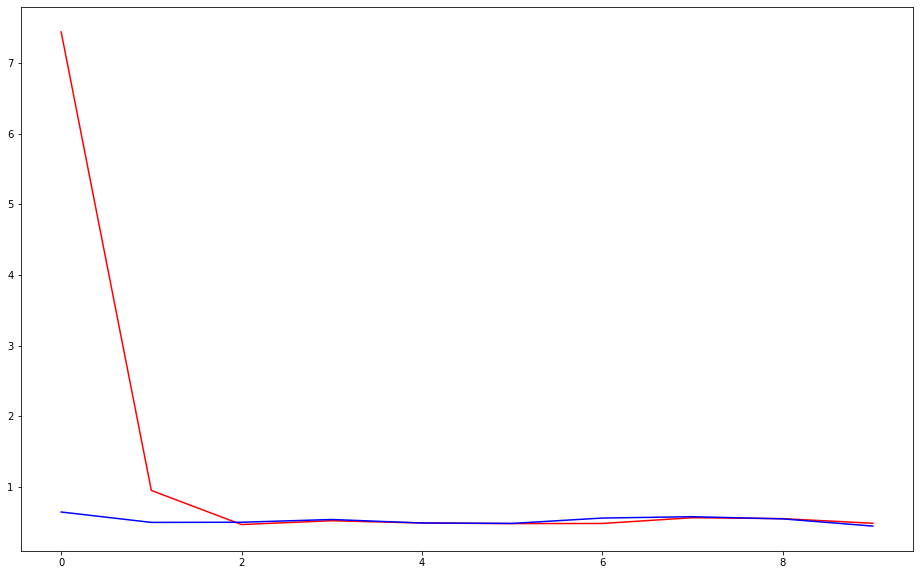

In [82]:
plt.figure(figsize=(16,10))
train_loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
plt.plot(train_loss,color="red")
plt.plot(val_loss,color="blue")

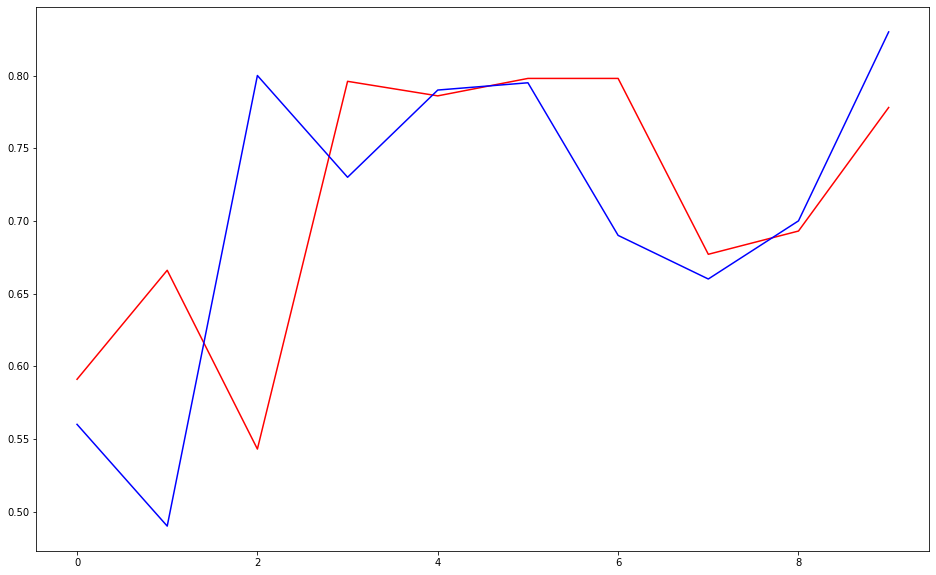

In [83]:
plt.figure(figsize=(16,10))
train_loss = model.history.history["accuracy"]
val_loss = model.history.history["val_accuracy"]
plt.plot(train_loss,color="red")
plt.plot(val_loss,color="blue")

In [109]:

import os
import pandas as pd
val_data = "ToyDataset/toy_val"
images = os.listdir(val_dir)
images_circle = [val_dir+"/circle"+"/"+img for img in os.listdir(val_dir+"/circle")]
images_rectangle = [val_dir+"/rectangle"+"/"+img for img in os.listdir(val_dir+"/rectangle")]
df_circle = pd.DataFrame({
    "image": images_circle,
    
})
df_rectangle = pd.DataFrame({
    "image": images_rectangle,
    
})


In [110]:
df_circle["label"] = 0
df_rectangle["label"]=1
final = pd.concat([df_circle,df_rectangle],axis=0)
final = final.sample(frac=1)
final = final.reset_index(drop=True)

In [116]:
prediction = []
for row in final["image"]:
    img = cv.imread(row)
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    prediction.append(pred)
    
prediction[:3]
    

[1, 0, 0]

In [117]:
from sklearn.metrics import confusion_matrix
confusion_matrix(final['label'].values,prediction)

array([[60, 38],
       [91, 11]], dtype=int64)

#### Observation
<pre>
Model seems to be overfitten ie has introduced high varience in it. 

Model has not generalized circle correctly.
</pre>



## Model 2
<pre>
Model with tweeking or learning
</pre>

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    
    rescale=1./255,

    )

val_datagen = ImageDataGenerator(rescale=1./255)

In [41]:
batch_size=64

train_generator = train_datagen.flow_from_directory(

                    directory='ToyDataset/toy_train/',
                    target_size=image_dim,
                    batch_size=batch_size,
                    
)

validation_generator = val_datagen.flow_from_directory(
    directory='ToyDataset/toy_val/',
    target_size=image_dim,
    batch_size=batch_size,
    )

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [161]:
image_size = (64,64,3)

# making the model
inputs = keras.layers.Input(shape=(image_size))
# x = keras.layers.Conv2D(512,3,activation="relu")(inputs)
x = keras.layers.Conv2D(256,3,activation="relu")(inputs)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(128,3,activation="relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(64,5,activation="relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(32,5,activation="relu")(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64,activation="relu")(x)
x = keras.layers.Dense(32,activation="relu")(x)
x = keras.layers.Dense(16,activation="relu")(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)

## defining the model
model = keras.models.Model(inputs=inputs,outputs=outputs)

In [162]:
epoch = 10
callbacks = keras.callbacks.EarlyStopping(patience=2, min_delta=0.01, monitor="val_loss")
opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics="accuracy")
model.fit(train_generator,validation_data=validation_generator,epochs=epoch,callbacks=callbacks)

Epoch 1/10
32/32 [==============================] - 20s 612ms/step - loss: 0.6446 - accuracy: 0.6130 - val_loss: 0.5270 - val_accuracy: 0.6700
Epoch 2/10
32/32 [==============================] - 21s 648ms/step - loss: 0.4458 - accuracy: 0.8000 - val_loss: 0.4187 - val_accuracy: 0.8350
Epoch 3/10
32/32 [==============================] - 21s 646ms/step - loss: 0.3835 - accuracy: 0.8370 - val_loss: 0.3743 - val_accuracy: 0.8350
Epoch 4/10
32/32 [==============================] - 20s 630ms/step - loss: 0.3745 - accuracy: 0.8390 - val_loss: 0.3752 - val_accuracy: 0.8350
Epoch 5/10
32/32 [==============================] - 22s 673ms/step - loss: 0.3703 - accuracy: 0.8390 - val_loss: 0.3698 - val_accuracy: 0.8350


In [140]:
# model.save("model1.h5") ## 83.50 percent accuracy
# model.save("model2.h5") ## 512 and dense 32 added

## Transfer Learning

<pre>
Since dataset is small we will freeze all the other layer for training, remove top layer 
</pre>

In [42]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [57]:
base_model = ResNet50(
     include_top=False,
    weights="imagenet",
    input_shape=(64,64,3)
                )
base_model.trainable = False
inputs = keras.layers.Input(shape=(64,64,3))
x = base_model(inputs)
# x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(2,activation="softmax")(x)

## defining the model
model = keras.models.Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 23,604,098
Trainable params: 16,386
Non-trainable params: 23,587,712
_________________________________________________________________


In [413]:
from tensorflow.keras import backend as K
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
epoch = 10
callbacks = keras.callbacks.EarlyStopping(patience=2, min_delta=0.01, monitor="val_loss")
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
# model.fit(train_generator,validation_data=validation_generator,epochs=epoch,callbacks=callbacks)

In [59]:
model.fit(train_generator,validation_data=validation_generator,epochs=epoch,callbacks=callbacks)

Epoch 1/10
16/16 [==============================] - 10s 517ms/step - loss: 0.6106 - accuracy: 0.6810 - val_loss: 0.4868 - val_accuracy: 0.8200
Epoch 2/10
16/16 [==============================] - 7s 441ms/step - loss: 0.4062 - accuracy: 0.8700 - val_loss: 0.3433 - val_accuracy: 0.9350
Epoch 3/10
16/16 [==============================] - 7s 447ms/step - loss: 0.3092 - accuracy: 0.9300 - val_loss: 0.2785 - val_accuracy: 0.9100
Epoch 4/10
16/16 [==============================] - 7s 458ms/step - loss: 0.2544 - accuracy: 0.9500 - val_loss: 0.2376 - val_accuracy: 0.9400
Epoch 5/10
16/16 [==============================] - 7s 471ms/step - loss: 0.2182 - accuracy: 0.9650 - val_loss: 0.2158 - val_accuracy: 0.9100
Epoch 6/10
16/16 [==============================] - 8s 484ms/step - loss: 0.1922 - accuracy: 0.9680 - val_loss: 0.1898 - val_accuracy: 0.9400
Epoch 7/10
16/16 [==============================] - 8s 480ms/step - loss: 0.1703 - accuracy: 0.9760 - val_loss: 0.1663 - val_accuracy: 0.9800
Epoch

In [67]:

model = keras.models.load_model("latest.h5")

### Testing Models....

In [68]:
# print(val_dir)
img_paths = "ToyDataset/toy_val"+"/circle"
for img in os.listdir(img_paths):
    img = cv.imread(img_paths+"/"+img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    print("Actual : ",0,"predicted : ", pred)
    

Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
Actual :  0 predicted :  0
A

In [69]:
img_paths = "ToyDataset/toy_val"+"/rectangle"
for img in os.listdir(img_paths):
    img = cv.imread(img_paths+"/"+img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    pred = model.predict(img)
    pred = np.argmax(pred)
    print("Actual : ",1,"predicted : ", pred)
    

Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  0
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
Actual :  1 predicted :  1
A

In [53]:
# model.save("tousemodel.h5")

In [223]:
# model.save("model100.h5")

### Observation 
<pre>
Various model wore trained and experimented, while Resnet gave the best result of 99 percent accuacy on validation data and 98 percent in train data.

While using the data augmentation, The result obtained was between 92-95 percent.
So only scaling the data gave the better result.

<b>Place for the improvement could be : </b>

1. Training the model with the black and white as color is not our main concern but cnn did right job in processing images with
out black and white.

2. If dataset was big, better the model would be.
</pre>